In [52]:
import akshare as ak 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os 
from datetime import datetime

In [53]:
STOCK_CODES = ["600519", "000858", "600938", "000333", "601088", "300866", "600900", "600036"]
STOCK_SYMBOLS_1 = [code + ".SH" if code.startswith("6") else code + ".SZ" for code in STOCK_CODES ]

today = pd.to_datetime("today").strftime("%Y%m%d")

### LOAD EPS, BPS, AND ROE

In [55]:
STOCK_CODES = ["600519", "000858", "600938", "000333", "601088", "300866", "600900", "600036"]
STOCK_SYMBOLS_1 = [code + ".SH" if code.startswith("6") else code + ".SZ" for code in STOCK_CODES ]

for stock_code in STOCK_CODES:
    try: 
        print(f"Processing stock code: {stock_code}")
        # --- STEP 1: get the financial data ---
        financial_df = ak.stock_financial_abstract_ths(symbol=f"{stock_code}", indicator="按单季度")
        # financial_df = ak.stock_financial_analysis_indicator_em(symbol='600519.SH', indicator="按单季度")
        # select the key indicators
        financial_df = financial_df[['报告期', '每股净资产', '基本每股收益', '净资产收益率']]
        # financial_df = financial_df[["REPORT_DATE", "BPS", "EPSJB", "ROE_DILUTED"]]
        # rename the columns
        financial_df.columns = ['report_date', 'bps', 'eps', 'roe']

        # chage the date format
        financial_df['report_date'] = pd.to_datetime(financial_df['report_date'])
        # choose the date later than 2010-01-01
        financial_df = financial_df[financial_df['report_date'] >= '2010-01-01']
        # change the data format
        financial_df['eps'] = financial_df['eps'].astype(float)
        financial_df['roe'] = financial_df['roe'].str.replace('%', '').astype(float)
        financial_df['bps'] = financial_df['bps'].astype(float)
        # calculate ttm eps and ttm roe
        financial_df['bps_ttm'] = financial_df['bps'].rolling(window=4).mean()
        financial_df['eps_ttm'] = financial_df['eps'].rolling(window=4).sum()
        financial_df['roe_ttm'] = financial_df['roe'].rolling(window=4).sum()
        # financial_df['bps_ttm'] = financial_df['bps'].rolling(window=4).mean().shift(-3)
        # financial_df['eps_ttm'] = financial_df['eps'].rolling(window=4).sum().shift(-3)
        # financial_df['roe_ttm'] = financial_df['roe'].rolling(window=4).sum().shift(-3)

        # drop the values with null values
        print("original shape: ", financial_df.shape)
        financial_df.dropna(inplace=True)
        print("shape after dropping rows with null values: ", financial_df.shape)
        # financial_df.head()

        # --- STEP 2: merge the financial data with standardized report dates ---
        # standardize the report dates
        date_df = pd.DataFrame(pd.date_range(start='2010-12-31', freq='QE'), columns=['report_date'])
        financial_date = pd.merge(date_df, financial_df, on='report_date', how='left', validate="1:1")
        print("The number of null values: ", financial_date.isna().sum().sum())
        print("The merged shape: ", financial_date.shape)
        # financial_date.head()

        # --- STEP 3: get the price data ---
        price_df = ak.stock_zh_a_hist(symbol=f"{stock_code}", period="monthly", start_date="20101231", adjust="")
        price_df = price_df[['日期', '股票代码', '开盘', '收盘', '最高', '最低']]
        price_df.columns = ['report_date', 'stock_code', 'open', 'clode', 'high', 'low']
        print("The merged shape with price df: ", price_df.shape)
        # price_df

        # --- STEP 4: merge the price data with financial data ---
        price_df['report_date'] = pd.to_datetime(price_df['report_date'])
        financial_price = pd.merge(price_df, financial_date, on='report_date', how='left', validate="1:1")
        financial_price = financial_price.ffill()

        # --- STEP 5: calculate pe_ttm, pb_ttm, pr_ttm ---
        financial_price['pe_ttm'] = financial_price['close'] / financial_price['eps_ttm']
        financial_price['pb_ttm'] = financial_price['close'] / financial_price['bps_ttm']
        financial_price['pr_ttm'] = financial_price['pe_ttm'] / financial_price['roe_ttm']
        financial_price['update_date'] = today
        print("The final shape: ", financial_price.shape)
        financial_price.to_csv(f"../data/processed/stock_valuation_{stock_code}_{today}.csv", index=False)
        print('--' * 50)
    except: 
        print(f"Failed to get the data for {stock_code}")
        print('--' * 50)
        continue


Processing stock code: 600519
original shape:  (63, 7)
shape after dropping rows with null values:  (60, 7)
Failed to get the data for 600519
----------------------------------------------------------------------------------------------------
Processing stock code: 000858
original shape:  (63, 7)
shape after dropping rows with null values:  (60, 7)
Failed to get the data for 000858
----------------------------------------------------------------------------------------------------
Processing stock code: 600938
original shape:  (19, 7)
shape after dropping rows with null values:  (12, 7)
Failed to get the data for 600938
----------------------------------------------------------------------------------------------------
Processing stock code: 000333
original shape:  (63, 7)
shape after dropping rows with null values:  (48, 7)
Failed to get the data for 000333
----------------------------------------------------------------------------------------------------
Processing stock code: 60108

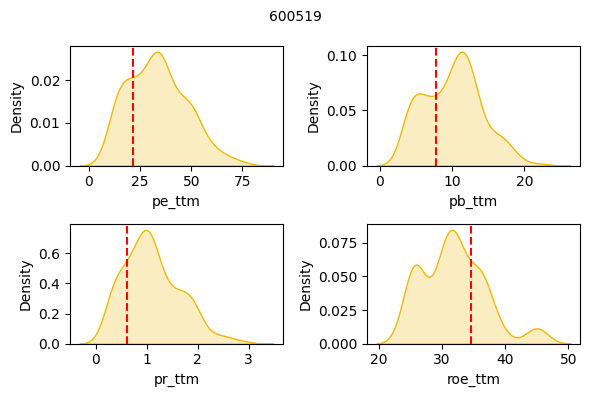

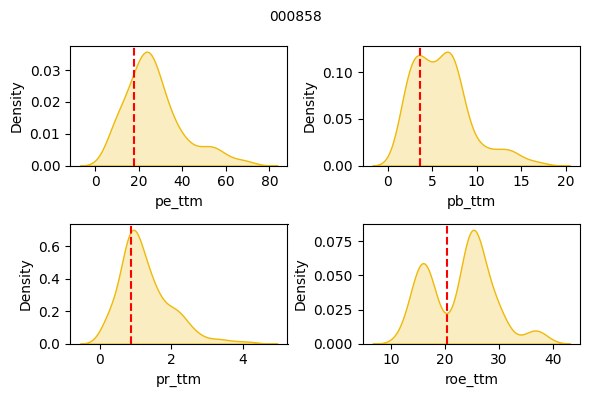

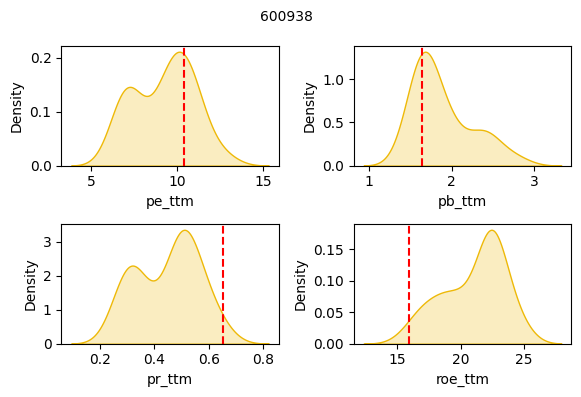

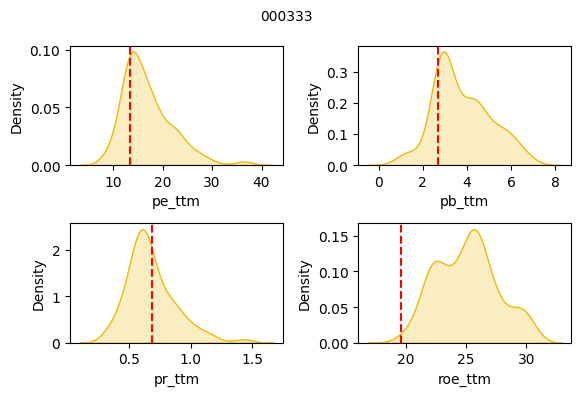

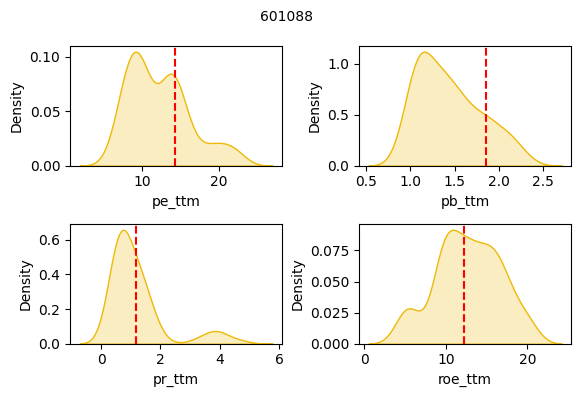

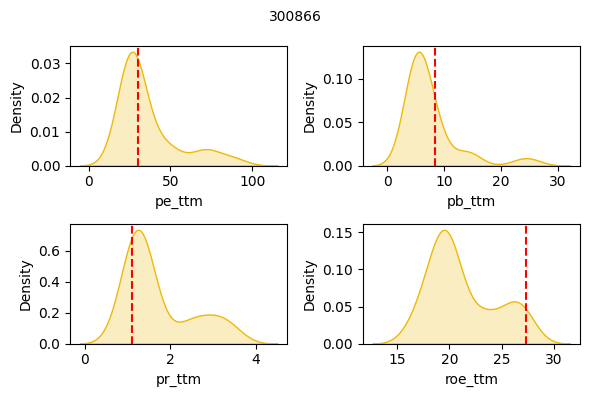

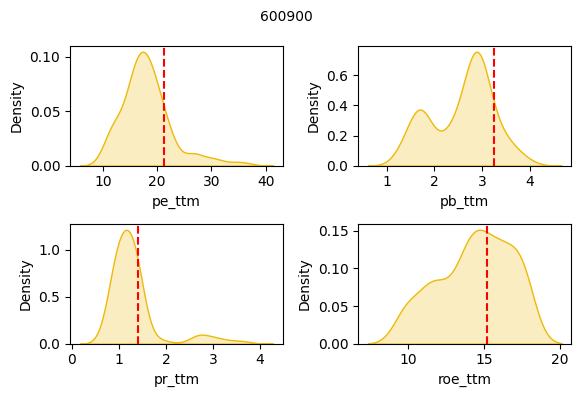

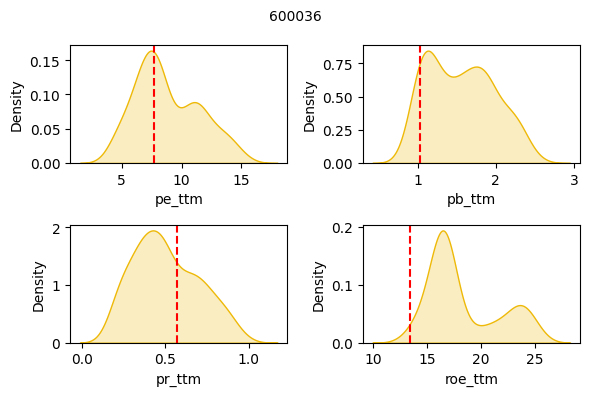

In [51]:
STOCK_CODES = ["600519", "000858", "600938", "000333", "601088", "300866", "600900", "600036"]
for stock_code in STOCK_CODES:
    financial_price = pd.read_csv(f"../data/processed/stock_valuation_{stock_code}.csv")

    fig, axes = plt.subplots(2, 2, figsize=(6, 4))
    axes = axes.flatten()

    # pe ttm distribution
    sns.kdeplot(financial_price, x='pe_ttm', fill=True, color="#eeb908", ax=axes[0])
    # current pe ttm
    axes[0].axvline(x=financial_price.iloc[-1, -3], color='red', linestyle='--')

    # pb ttm distribution
    sns.kdeplot(financial_price, x='pb_ttm', fill=True, color="#eeb908", ax=axes[1])
    # current pb ttm
    axes[1].axvline(x=financial_price.iloc[-1, -2], color='red', linestyle='--')

    # pr ttm distribution
    sns.kdeplot(financial_price, x='pr_ttm', fill=True, color="#eeb908", ax=axes[2])
    # current pr ttm
    axes[2].axvline(x=financial_price.iloc[-1, -1], color='red', linestyle='--')

    # roe ttm distribution
    sns.kdeplot(financial_price, x='roe_ttm', fill=True, color="#eeb908", ax=axes[3])
    # current roe ttm
    axes[3].axvline(x=financial_price.iloc[-1, -4], color='red', linestyle='--')

    fig.suptitle(f"{stock_code}", fontsize=10)
    plt.tight_layout()
    # plt.legend()
   
    # save the image
    plt.savefig(f"../img/pe_pb_pr_roe_distribution_{stock_code}.png", dpi=300)
    plt.show()